<a href="https://colab.research.google.com/github/YCYoon2015/DL_zero_to_all_PyTorch/blob/master/210803_ch10_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ML 학습 단계.

1. 라이브러리 가져오기
2. GPU 사용설정. random value를 위한 seed 설정
3. 학습 파라미터 설정(learning_rate, traing_epochs, batch_size 등)
4. 데이터 셋 가져오고 loader 만들기
5. 학습 모델 만들기
6. Loss function (Criterion)을 선택하고 최적화 도구 선택(optimizer)
7. 모델 학습 및 loss check(Criterion의 output)
8. 학습된 모델의 성능 확인

In [ ]:
import torch
import torch.nn as nn

In [ ]:
inputs = torch.Tensor(1,1,28,28)

In [ ]:
inputs.shape

torch.Size([1, 1, 28, 28])

In [ ]:
conv1 = nn.Conv2d(1,32,3,padding=1)

In [ ]:
pool = nn.MaxPool2d(2)

In [ ]:
pool

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
conv2 = nn.Conv2d(32,64,3,padding=1)

In [ ]:
out = conv1(inputs)

In [ ]:
out.shape

torch.Size([1, 32, 28, 28])

In [ ]:
out = pool(out)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
out.shape

torch.Size([1, 32, 14, 14])

In [ ]:
out = conv2(out)

In [ ]:
out = pool(out)

In [ ]:
out.shape

torch.Size([1, 64, 7, 7])

Test 1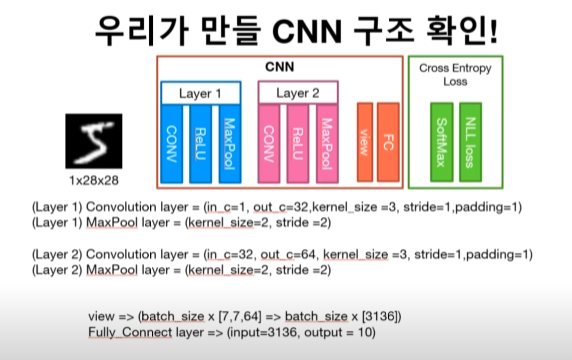

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(555) # 랜덤값을 시드를 이용해서 고정시킨다.
if device == 'cuda':
  torch.cuda.manual_seed(555)

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST datset (torchvision에서 받는다.)

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(), # 받아온 데이터를 텐서로 만든다.
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False, # 여기에 false는 테스트 데이터를 의미한다.
                         transform=transforms.ToTensor(),
                         download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# data loader를 적용한다.

data_loader = torch.utils.data.DataLoader(dataset=mnist_train, # 학습에 사용할 데이터 셋이다.
                                          batch_size=batch_size, # 크기 지정(위에서 설정함)
                                          shuffle=True, # 데이터셋을 섞은 상태로 학습시킨다.
                                          drop_last=True)

In [9]:
# 모델 만들기

class CNN(torch.nn.Module): # 파이토치에서 상속받아 시작한다.

  def __init__(self):
    super(CNN, self).__init__() # 초기함수

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 왜 이렇게 잡았을까?
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    ) # 앞서 손으로 진행한 L1, Conv, Pool 과정이다.

    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32를받아 64를 보내고
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    ) # FC 7x7x64 inputs -> 10 outputs

    self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True) # 7*7*64는 두번째 layer를 거치면 나온다. 여기 out은 10개다.
    torch.nn.init.xavier_uniform_(self.fc.weight) # 초기화

  def forward(self, x):
    out = self.layer1(x) # layer1을 통과한다
    out = self.layer2(out) # layer2를통과한다
    out = out.view(out.size(0), -1) # view로 한줄로 펼친다.
    out = self.fc(out)
    return out

In [10]:
model  = CNN().to(device)

In [11]:
criterion = torch.nn.CrossEntropyLoss().to(device) # 이용하기로 한 손실함수이다. 왜 이걸로 할까?
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 아담 옵티마이저

In [14]:
total_batch = len(data_loader)
print('Learning started')
for epoch in range(training_epochs):
  avg_cost = 0 # 여기에 loss를 담는다.

  for X, Y in data_loader: # X는 이미지고 Y는 라벨이다.
    X = X.to(device) # 사용하는 장치에 맞게 텐서가 지정되어있어야 한다.
    Y = Y.to(device)

    optimizer.zero_grad() 
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step() 

    avg_cost += cost/total_batch

  print('[Epoch: {:>4} cost = {:>.9}'.format(epoch + 1, avg_cost))
print('end')

Learning started


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch:    1 cost = 0.231220603
[Epoch:    2 cost = 0.0652029514
[Epoch:    3 cost = 0.0472799726
[Epoch:    4 cost = 0.0372297429
[Epoch:    5 cost = 0.0308244657
[Epoch:    6 cost = 0.0262094848
[Epoch:    7 cost = 0.0223919582
[Epoch:    8 cost = 0.0189750977
[Epoch:    9 cost = 0.0163925756
[Epoch:   10 cost = 0.0143746873
[Epoch:   11 cost = 0.0109881246
[Epoch:   12 cost = 0.0106444024
[Epoch:   13 cost = 0.00945081003
[Epoch:   14 cost = 0.00740125403
[Epoch:   15 cost = 0.00672267657
end


In [15]:
with torch.no_grad(): # 테스트는 학습하지 않는다.
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device) # 값을 한번에 집어넣으려고 펼친것
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test # 같은지 판단한다.
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9853000044822693


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
